In [6]:
!pip install einops

   ---------------------------------------- 0.0/43.2 kB ? eta -:--:--
   --------- ------------------------------ 10.2/43.2 kB ? eta -:--:--
   ------------------ --------------------- 20.5/43.2 kB 320.0 kB/s eta 0:00:01
   ---------------------------- ----------- 30.7/43.2 kB 262.6 kB/s eta 0:00:01
   ---------------------------------------- 43.2/43.2 kB 233.9 kB/s eta 0:00:00


In [7]:
import torch
from torch.nn import functional as F
from torch import nn
import os
from torch.utils.data import Dataset, DataLoader
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms
from pathlib import Path
import random
from PIL import Image
import seaborn as sns
import pandas as pd
from torchinfo import summary
from torchvision import models
from torch.optim import lr_scheduler
import einops

In [26]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)
latentsize = 768
patchsize =16
n_channels = 3
num_heads = 12
num_encoders = 12
dropout = 0.1
num_classes = 2
size = 224

epochs = 10
base_lr = 10e-3
weight_decay = 0.03
batchsize = 4

cuda:0


cat


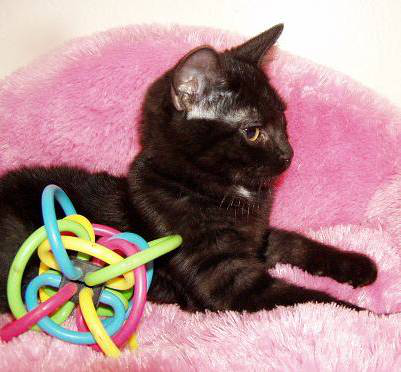

In [27]:
image_path = Path('data/cat_dog')
imagelist = list(image_path.glob('*/*/*.jpg'))
random_image_path = random.choice(imagelist)
print(random_image_path.stem[:3])
Image.open(random_image_path)

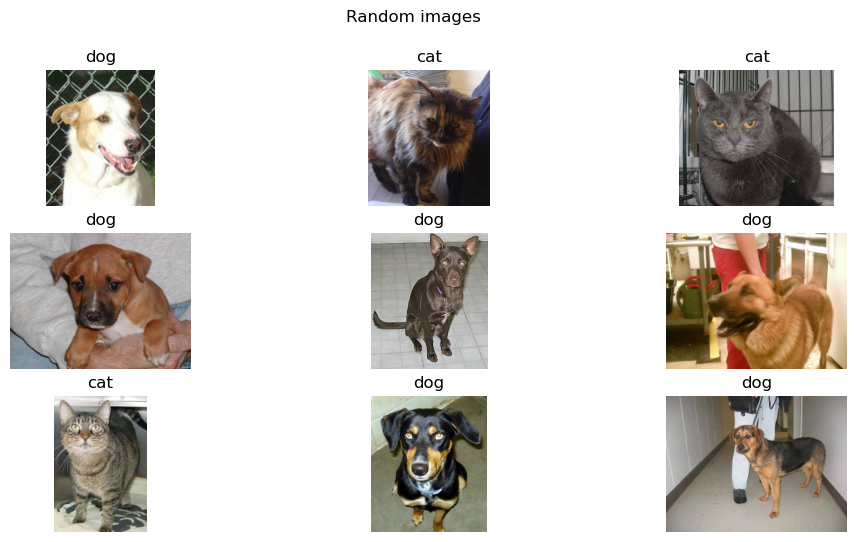

In [28]:
n_rows = 3
n_cols = 3
fig = plt.figure(figsize=(12, 6))

for i in range(1, n_rows*n_cols+1):
    rand_img_path = random.choice(imagelist)
    fig.add_subplot(n_rows, n_cols, i)
    plt.imshow(plt.imread(rand_img_path))
    plt.title(rand_img_path.stem[:3])
    plt.axis(False)
    plt.suptitle('Random images')

plt.show()

In [29]:
dim1_mean, dim2_mean = (360, 404)
dim1_mean, dim2_mean

(360, 404)

In [30]:
# dim1_mean, dim2_mean = dim1_mean//8, dim2_mean//8
dim1_mean, dim2_mean = 224, 224

cus_transfrom = transforms.Compose([
    transforms.Resize(size=[dim1_mean, dim2_mean]),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

torch.Size([3, 224, 224])


(-0.5, 223.5, 223.5, -0.5)

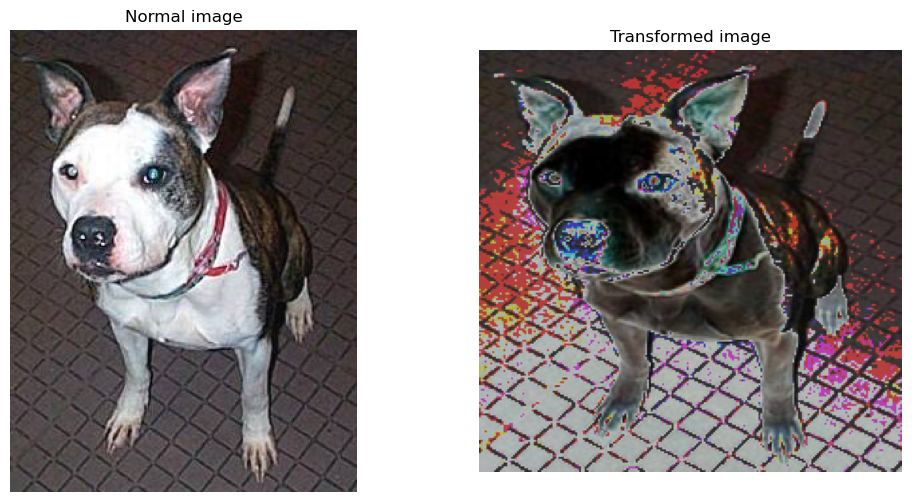

In [31]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
image = imagelist[random.randint(0, len(imagelist))]
transformed_image = cus_transfrom(Image.open(image))
print(transformed_image.shape)
ax[0].imshow(plt.imread(image))
ax[0].set_title('Normal image')
ax[0].axis(False)
ax[1].imshow(transformed_image.permute(1,2,0))
ax[1].set_title('Transformed image')
ax[1].axis(False)

In [32]:
trainpath = Path('data/cat_dog/train/')
testpath = Path('data/cat_dog/test/')

def get_classes(path: Path):
    classes = [folder.name for folder in os.scandir(path) if folder.is_dir()]
    classes_to_idx = {k:v for v, k in enumerate(classes)}
    return classes, classes_to_idx
get_classes(trainpath)

(['cat', 'dog'], {'cat': 0, 'dog': 1})

In [33]:
class ImageDataset(Dataset):
    def __init__(self, target_dir: str, transform: torchvision.transforms = None):
        super().__init__()
        self.paths = list(Path(target_dir).glob('*/*.jpg'))
        self.transform = transform
        self.classes, self.classes_to_idx = get_classes(target_dir)

    def load_image(self, idx):
        return Image.open(self.paths[idx])

    def __getitem__(self, idx):
        img = self.load_image(idx)
        class_name = self.paths[idx].parent.name
        class_idx = self.classes_to_idx[class_name]
        if self.transform:
            img = self.transform(img)
        return img, class_idx

    def __len__(self):
        return len(self.paths)

In [34]:
train_transforms = transforms.Compose([
    transforms.Resize(size=[64, 64]),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])
test_transforms = transforms.Compose([
    transforms.Resize(size=[64, 64]),
    transforms.ToTensor()
])

In [35]:
train_dataset = ImageDataset(trainpath, transform=train_transforms)
test_dataset = ImageDataset(testpath, transform=test_transforms)

len(train_dataset), len(test_dataset)

(20000, 5000)

torch.Size([3, 64, 64])


(<matplotlib.image.AxesImage at 0x1e7abdd1240>, 0)

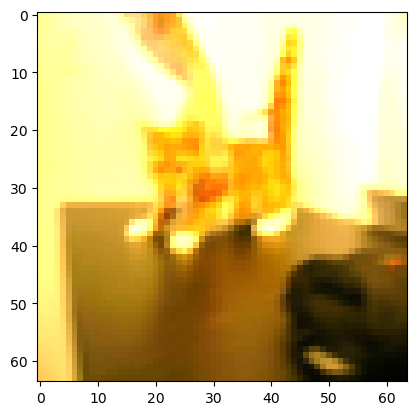

In [36]:
img = next(iter(train_dataset))
print(img[0].shape)
plt.imshow(img[0].permute(1,2,0)), img[1]

torch.Size([3, 64, 64])


(<matplotlib.image.AxesImage at 0x1e7abf0d150>, 0)

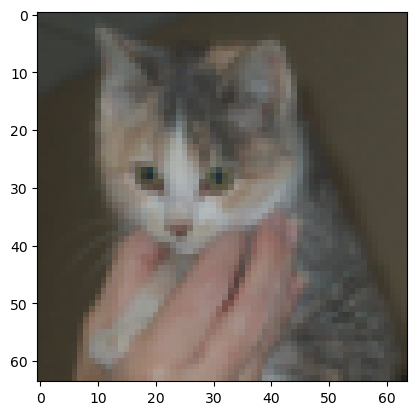

In [37]:
img = next(iter(test_dataset))
print(img[0].shape)
plt.imshow(img[0].permute(1,2,0)), img[1]

In [38]:
batch = batchsize
train_dataloader = DataLoader(train_dataset, batch_size=batch, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch)

len(train_dataloader), len(test_dataloader)

(5000, 1250)

In [62]:
# Implementing input linear projection

class InputEmbedding(nn.Module):
    def __init__(self, patchsize=patchsize, n_channels=n_channels, device=device, latentsize=latentsize, batchsize=batchsize):
        super().__init__()
        self.patchsize = patchsize
        self.n_channels = n_channels
        self.device = device
        self.latentsize = latentsize
        self.batchsize = batchsize
        self.inputsize = self.patchsize * self.patchsize * 3

        # Linear proj layer
        self.linear_proj = nn.Linear(self.inputsize, self.latentsize)
        # Class token
        self.class_token = nn.Parameter(torch.randn(size=[self.batchsize, 1, self.latentsize])).to(device)
        # Positional encoding
        self.pos_embedding = nn.Parameter(torch.randn(size=[self.batchsize, 1, self.latentsize])).to(device)

    def forward(self, x):
        x = x.to(device)
        # print(x.shape)
        # Patchify input image
        patches = einops.rearrange(
            x, 'b c (h h1) (w w1) -> b (h w) (h1 w1 c)', h1=self.patchsize, w1=self.patchsize
        )
        print(x.shape)
        print(patches.shape)

        linear_projection = self.linear_proj(patches).to(device)
        b, n, _ = linear_projection.shape
        
        linear_projection = torch.cat([self.class_token, linear_projection], dim=1)
        pos_embed = einops.repeat(self.pos_embedding, 'b 1 d -> b m d', m=n+1)

        print(linear_projection.shape)
        print(pos_embed.shape)

        linear_projection += pos_embedding

        return linear_projection

In [61]:
test_input = torch.randn([4, 3, 224, 224])
test_class = InputEmbedding().to(device)
test_class(test_input)

torch.Size([4, 3, 224, 224])
torch.Size([4, 196, 768])
torch.Size([4, 197, 768])
torch.Size([4, 197, 768])
